In [22]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from collections import Counter
import joblib

dataset_root = "/kaggle/input/fer2013/train"
subdirs = os.listdir(dataset_root)
if len(subdirs) == 1 and os.path.isdir(os.path.join(dataset_root, subdirs[0])):
    dataset_root = os.path.join(dataset_root, subdirs[0])
print("Đang dùng dataset_root =", dataset_root)

X, y = [], []
counts = Counter()
valid_ext = (".jpg", ".jpeg", ".png")

def preprocess_img(img):

    img = cv2.resize(img, (48,48))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return img

for label in os.listdir(dataset_root):
    label_path = os.path.join(dataset_root, label)
    if not os.path.isdir(label_path):
        continue
    for fname in os.listdir(label_path):
        if not fname.lower().endswith(valid_ext):
            continue
        fpath = os.path.join(label_path, fname)
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Lỗi đọc ảnh: {fpath}")
            continue

        
        img = preprocess_img(img)
        
        features = hog(img, orientations=9, pixels_per_cell=(4,4),
                       cells_per_block=(2,2), block_norm='L2-Hys')
        X.append(features)
        y.append(label.lower())
        counts[label.lower()] += 1

X = np.array(X)
y = np.array(y)
print("Tổng số mẫu:", len(X))
print("Số lượng theo nhãn:", counts)

joblib.dump((X, y), "hog_features_improved.pkl")
print(" Đã lưu HOG features cải tiến vào 'hog_features_improved.pkl'")


Đang dùng dataset_root = /kaggle/input/fer2013/train
Tổng số mẫu: 28709
Số lượng theo nhãn: Counter({'happy': 7215, 'neutral': 4965, 'sad': 4830, 'fear': 4097, 'angry': 3995, 'surprise': 3171, 'disgust': 436})
 Đã lưu HOG features cải tiến vào 'hog_features_improved.pkl'


In [23]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

X, y = joblib.load("hog_features_improved.pkl")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=250, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Tổng phương sai giữ lại:", np.sum(pca.explained_variance_ratio_))


rf = RandomForestClassifier( 
    n_estimators=800, 
    max_depth=6, 
    min_samples_split=30, 
    min_samples_leaf=12, 
    max_features='log2', 
    bootstrap=True, 
    class_weight='balanced', 
    random_state=42, 
    n_jobs=-1 
)

rf.fit(X_train_pca, y_train)

y_train_pred = rf.predict(X_train_pca)
y_test_pred = rf.predict(X_test_pca)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

results_df = pd.DataFrame({
    "Tập dữ liệu": ["Train", "Test"],
    "Số mẫu": [len(X_train), len(X_test)],
    "Accuracy": [f"{train_acc:.4f}", f"{test_acc:.4f}"]
})
print("\n=== Kết quả tổng quan ===")
print(results_df.to_string(index=False))

print("\n=== Classification Report ===")
print(pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T.round(3))

joblib.dump(scaler, "scaler.joblib")
joblib.dump(pca, "pca.joblib")
joblib.dump(rf, "rf_model.joblib")
print("Đã lưu mô hình vào các file .joblib")


Tổng phương sai giữ lại: 0.5140053024947007

=== Kết quả tổng quan ===
Tập dữ liệu  Số mẫu Accuracy
      Train   22967   0.4620
       Test    5742   0.3807

=== Classification Report ===
              precision  recall  f1-score   support
angry             0.271   0.272     0.271   799.000
disgust           0.349   0.437     0.388    87.000
fear              0.331   0.120     0.176   820.000
happy             0.518   0.651     0.577  1443.000
neutral           0.355   0.356     0.356   993.000
sad               0.282   0.156     0.201   966.000
surprise          0.327   0.614     0.427   634.000
accuracy          0.381   0.381     0.381     0.381
macro avg         0.347   0.372     0.342  5742.000
weighted avg      0.365   0.381     0.356  5742.000
Đã lưu mô hình vào các file .joblib


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, make_scorer


# Cross-validation - Accuracy
cv_acc_scores = cross_val_score(
    rf, X_train_pca, y_train, cv=5, scoring='accuracy', n_jobs=-1
)
print("\n=== Cross-validation (Accuracy - 5 folds) ===")
print("Scores:", cv_acc_scores)
print(f"Mean Accuracy: {np.mean(cv_acc_scores):.4f}")

# Cross-validation - F1-score (weighted)
cv_f1_scores = cross_val_score(
    rf, X_train_pca, y_train, cv=5,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
print("\n=== Cross-validation (F1-score - 5 folds) ===")
print("Scores:", cv_f1_scores)
print(f"Mean F1-score: {np.mean(cv_f1_scores):.4f}")



=== Cross-validation (Accuracy - 5 folds) ===
Scores: [0.37766652 0.37527209 0.37992597 0.38166776 0.38580449]
Mean Accuracy: 0.3801

=== Cross-validation (F1-score - 5 folds) ===
Scores: [0.35724798 0.35341669 0.35862907 0.35710096 0.36297221]
Mean F1-score: 0.3579


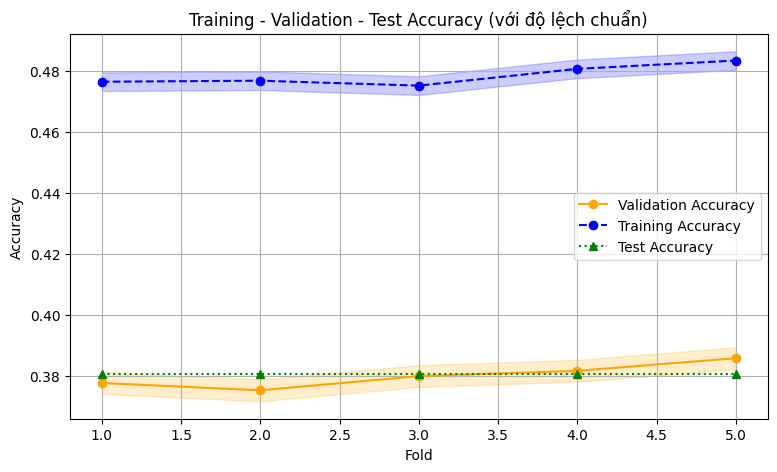

 Training Accuracy: 0.4786
 Validation Accuracy: 0.3801
 Test Accuracy: 0.3807


In [25]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Dùng cross_validate để lấy cả training score và validation score
cv_results = cross_validate(
    rf, X_train_pca, y_train,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

train_scores = cv_results['train_score']
val_scores = cv_results['test_score']

# Tạo mảng test score để vẽ đường phẳng
test_scores = np.full_like(val_scores, test_acc)

# Vẽ 3 đường
plt.figure(figsize=(9,5))
plt.plot(range(1,6), val_scores, 'o-', color='orange', label='Validation Accuracy')
plt.fill_between(range(1,6),
                 val_scores - np.std(val_scores),
                 val_scores + np.std(val_scores),
                 alpha=0.2, color='orange')

plt.plot(range(1,6), train_scores, 'o--', color='blue', label='Training Accuracy')
plt.fill_between(range(1,6),
                 train_scores - np.std(train_scores),
                 train_scores + np.std(train_scores),
                 alpha=0.2, color='blue')

plt.plot(range(1,6), test_scores, '^:', color='green', label='Test Accuracy')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Training - Validation - Test Accuracy (với độ lệch chuẩn)")
plt.legend()
plt.grid(True)
plt.show()


# In giá trị trung bình để tiện theo dõi
print(f" Training Accuracy: {np.mean(train_scores):.4f}")
print(f" Validation Accuracy: {np.mean(val_scores):.4f}")
print(f" Test Accuracy: {test_acc:.4f}")


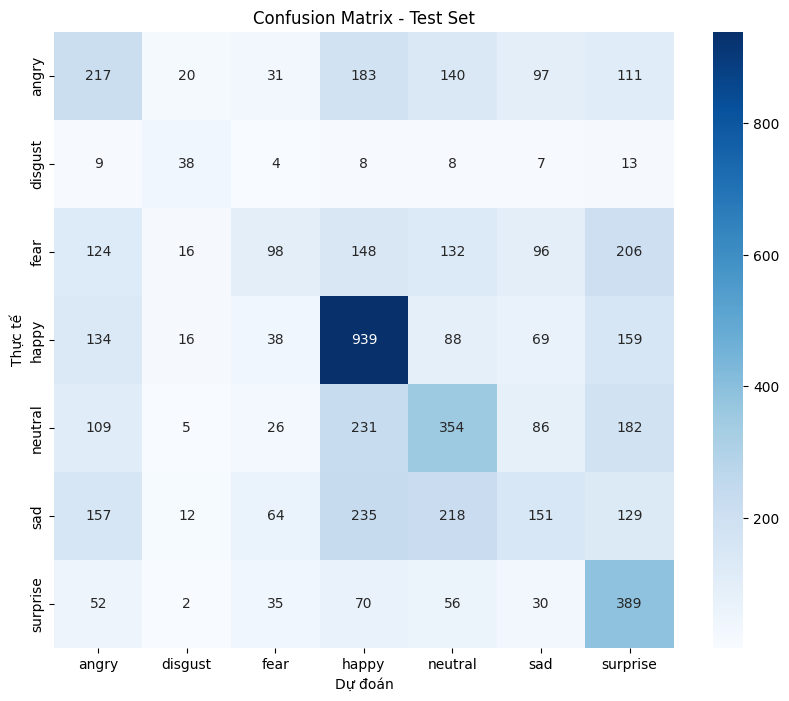

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tính ma trận nhầm lẫn trên tập test
cm = confusion_matrix(y_test, y_test_pred, labels=rf.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf.classes_,
            yticklabels=rf.classes_)

plt.title("Confusion Matrix - Test Set")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()


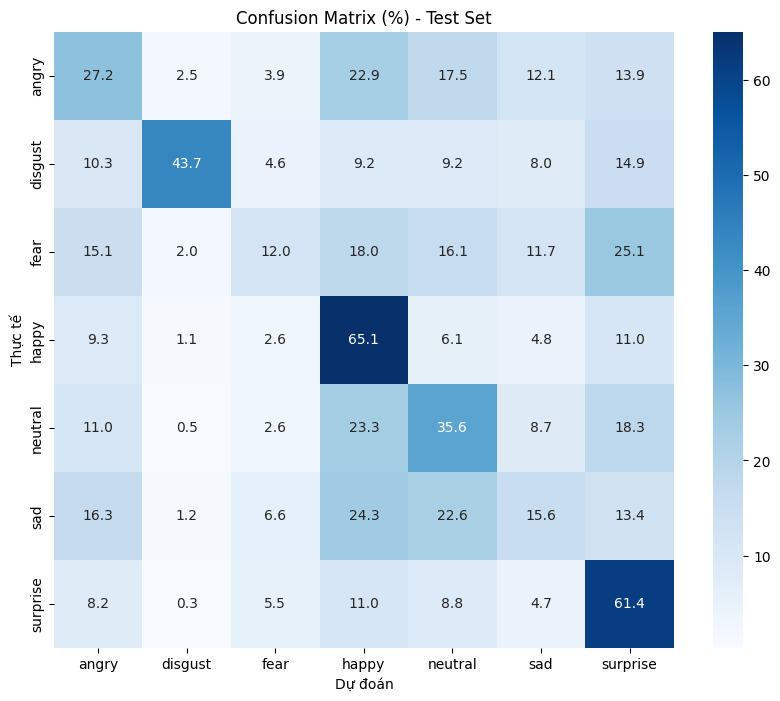

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Tính ma trận nhầm lẫn
labels = rf.classes_
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

# Chuyển sang % theo từng hàng (nhãn thật)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix (%) - Test Set")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()


 Phát hiện 29 khuôn mặt


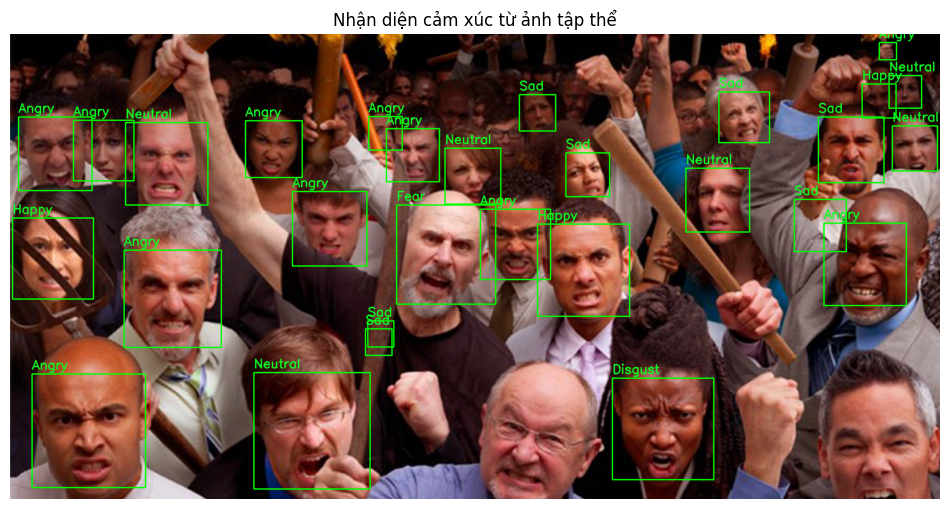

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
from skimage.feature import hog

# Load model, scaler, PCA
X, y = joblib.load("hog_features_improved.pkl")
scaler = joblib.load("scaler.pkl") if os.path.exists("scaler.pkl") else None
pca = joblib.load("pca.pkl") if os.path.exists("pca.pkl") else None
rf = joblib.load("rf_model.pkl") if os.path.exists("rf_model.pkl") else None

# Nếu scaler, pca, rf chưa được lưu trước đó, tạo lại từ đầu:
if scaler is None or pca is None or rf is None:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.ensemble import RandomForestClassifier

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=150, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    rf = RandomForestClassifier(
        n_estimators=200, max_depth=6, min_samples_split=30,
        min_samples_leaf=12, max_features='log2', bootstrap=True,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    rf.fit(X_pca, y)

    # Lưu lại để dùng sau
    joblib.dump(scaler, "scaler.pkl")
    joblib.dump(pca, "pca.pkl")
    joblib.dump(rf, "rf_model.pkl")

# Load ảnh tập thể
group_img_path = "/kaggle/input/angry-among/demo_02.jpg" 
image = cv2.imread(group_img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Load Haar Cascade để phát hiện khuôn mặt
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Phát hiện khuôn mặt
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

print(f" Phát hiện {len(faces)} khuôn mặt")

def preprocess_face(face_img):
    face_img = cv2.resize(face_img, (48, 48))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    face_img = clahe.apply(face_img)
    return face_img

# Dự đoán từng khuôn mặt
for (x, y_, w, h) in faces:
    face = gray[y_:y_+h, x:x+w]
    face_processed = preprocess_face(face)

    features = hog(face_processed, orientations=9, pixels_per_cell=(4,4),
                   cells_per_block=(2,2), block_norm='L2-Hys').reshape(1, -1)

    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    prediction = rf.predict(features_pca)[0]
    label = prediction.capitalize()

    # Vẽ khung và nhãn trên ảnh gốc
    cv2.rectangle(image, (x, y_), (x+w, y_+h), (0, 255, 0), 2)
    cv2.putText(image, label, (x, y_-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

# Hiển thị ảnh kết quả
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Nhận diện cảm xúc từ ảnh tập thể")
plt.show()
